# RBF-FD Method

### 

In [1]:
# Import numpy
import numpy as np

## Node distribution setup

In [2]:
# Set up the domain and create the cartesian node distribution - RBF centers
# You can use other node distributions as well - if that's the case, code it up here and label your x coordinates as 'x' and y
#coordinates as 'y'

# Domain is [a,b] X [c,d] 
a=-2;
b=2;
c=-2;
d=2;

Nx=100; # Number of nodes on the x axis 
Ny=100; # Number of nodes on the y axis 

# Line space
x1=np.linspace(a,b,Nx);
y1=np.linspace(c,d,Ny);

# Create a meshgrid
xd, yd = np.meshgrid(x1, y1);

# Nodes (x,y)
x=xd.flatten('F');
y=yd.flatten('F');

# If you want to look at the node distribution uncomment the following 4 commands

#import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (20,20)
#plt.plot(x,y,'.')
#plt.show()


## Define the radial basis functions

### Here I have used polyharmonic splines

In [3]:
import math

def phi(X1,X2,Y1,Y2,epsil):
    return np.sqrt(np.power((np.power(X1-X2,2)+np.power(Y1-Y2,2)),epsil))

# Derivative with respective to x of phi
def phi_x(X1,X2,Y1,Y2,epsil):
    return -1*epsil*np.multiply((X1-X2),np.sqrt(np.power((np.power(X1-X2,2)+np.power(Y1-Y2,2)),epsil-2)))

# Derivative with respective to y of phi
def phi_y(X1,X2,Y1,Y2,epsil):
    return -1*epsil*np.multiply((Y1-Y2),np.sqrt(np.power((np.power(X1-X2,2)+np.power(Y1-Y2,2)),epsil-2)))

# Laplacian of phi
def phi_lap(X1,X2,Y1,Y2,epsil):
    return -4*epsil**2*np.exp(-(epsil**2)*(np.power(X1-X2,2)+np.power(Y1-Y2,2)))+4*epsil**2*np.multiply((np.power(X1-X2,2)+np.power(Y1-Y2,2)),np.exp(-(epsil**2)*(np.power(X1-X2,2)+np.power(Y1-Y2,2))))


## Parameters 

In [4]:
# Augmented polynomial degree
p=4; 

# RBF Order
m=7;

# Number of neighbors 
n=((p+2)*(p+1))+7;

# Number of terms in the augmented polynomial
P=int((p+2)*(p+1)/2);




## Let's separate nodes on the boundary and interior nodes - This is optional

In [5]:

# All the boundary nodes
delta_om=np.where((y==d)  | (y==c) | (x==a) | (x==b))[0];

# let's count the number of nodes on the boundary
NBC=delta_om.shape[0]

# Nodes on the top horizontal boundary
delta_om_top=np.where((y==d) & (x!=a) & (x!=b))[0];

# let's count the number of nodes on the top horizontal boundary
Ntop=delta_om_top.shape[0];

# Nodes on the bottom horizontal boundary
delta_om_bot=np.where((y==c) & (x!=a) & (x!=b))[0];

# let's count the number of nodes on the bottom horizontal boundary
Nbot=delta_om_bot.shape[0];

# Nodes on the left vertical boundary
delta_om_left=np.where((x==a))[0];

# let's count the number of nodes on the left vertical boundary
Nleft=delta_om_left.shape[0];

# Nodes on the right vertical boundary
delta_om_right=np.where((x==b))[0];

# let's count the number of nodes on the right vertical boundary
Nright=delta_om_right.shape[0]

# Total number of nodes
N=x.shape[0];

# All indexes of the points
index=np.linspace(0,N-1,N,dtype=int);

# All interior nodes

index_om=np.setdiff1d(index,delta_om)

# Let's count the number of interior nodes

Nin=index_om.shape[0];




## Rearranging nodes - Organizing nodes and categorizing based on the boundary

The rearrangment is made like:
1. Nodes in the interior
2. Nodes on the left vertical boundary
3. Nodes on the right vertical boundary
4. Nodes on the top horizontal boundary
5. Nodes on the bottom horizontal boundary

In [6]:
# New rearranged x nodes
xnew=np.concatenate((x[index_om], x[delta_om_left], x[delta_om_right], x[delta_om_top], x[delta_om_bot]),axis=None);
# New rearranged y nodes
ynew=np.concatenate((y[index_om], y[delta_om_left], y[delta_om_right], y[delta_om_top], y[delta_om_bot]),axis=None);

del index_om, delta_om_left, delta_om_right, delta_om_top, delta_om_bot, x, y

x=xnew;
y=ynew;

# Let's get the indices

# All interior nodes
index_om=np.linspace(0,Nin-1,Nin,dtype=int);

# Nodes on the left vertical boundary
delta_om_left=np.linspace(Nin,(Nin+Nleft)-1,Nleft,dtype=int);

# Nodes on the right vertical boundary
delta_om_right=np.linspace(Nin+Nleft,(Nin+Nleft+Nright)-1,Nright,dtype=int);

# Nodes on the top horizontal boundary
delta_om_top=np.linspace(Nin+Nleft+Nright,(Nin+Nleft+Nright+Ntop)-1,Ntop,dtype=int);

# Nodes on the bottom horizontal boundary
delta_om_bot=np.linspace(Nin+Nleft+Nright+Ntop,(Nin+Nleft+Nright+Ntop+Nbot)-1,Nbot,dtype=int);

# If you want to look at the reordered domain, uncomment what's below

#plt.rcParams["figure.figsize"] = (20,20)
#plt.plot(xnew[index_om],ynew[index_om],'.')
#plt.plot(xnew[delta_om_left],ynew[delta_om_left],'b.')
#plt.plot(xnew[delta_om_right],ynew[delta_om_right],'r.')
#plt.plot(xnew[delta_om_top],ynew[delta_om_top],'y.')
#plt.plot(xnew[delta_om_bot],ynew[delta_om_bot],'k.')
#plt.show()

## Create augmented polynomial exponents

In [7]:
# Create the polynomial exponents

import numpy.matlib

x_exp=np.array([]);
y_exp=np.array([]);
for i_exp in range(0, p+1):
    x_exp=np.append(x_exp, np.arange(i_exp+1))
    y_exp=np.append(y_exp, i_exp-np.arange(i_exp+1))


x_exp=np.transpose(x_exp.astype(int)); # Exponents of 'x' of the bivariate polynomial
y_exp=np.transpose(y_exp.astype(int)); # Exponents of 'y' of the bivariate polynomial
x_exp=x_exp.reshape(1,-1);
y_exp=y_exp.reshape(1,-1);

# Create a repititive matrix our those exponets - will be needing later
ax_exp=np.matlib.repmat(x_exp,n,1);
ay_exp=np.matlib.repmat(y_exp,n,1);

# Derivatives of the exponents

x_exp_Dx=x_exp-1;
x_exp_Dx[x_exp_Dx <0]=0;
x_exp_Dxx=x_exp-2;
x_exp_Dxx[x_exp_Dxx <0]=0;

y_exp_Dy=y_exp-1;
y_exp_Dy[y_exp_Dy <0]=0;
y_exp_Dyy=y_exp-2;
y_exp_Dyy[y_exp_Dyy <0]=0;


# Find the nearest neighbors

dsites=np.column_stack((x,y));
# dist is the distances to the nearest neighbors
# idx is the indices of the nearest neighbors

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=n, algorithm='kd_tree').fit(dsites);
dist, idx = nbrs.kneighbors(dsites);

 

## Setup the differentiation matrices

In [8]:

from numpy.linalg import inv

Dx=np.zeros((N,N)); # Differentiation matrix to store weights for 'x' derivative
Dy=np.zeros((N,N)); # Differentiation matrix to store weights for 'y' derivative
Dlap=np.zeros((N,N)); # Differentiation matrix to store weights for laplacian

for index in range(0,N):
    # Scaling factor - recenter all nodes to the origin and scale
    sc=dist[index,n-1];
   
    xn=(dsites[idx[index,:],0]-dsites[idx[index,0],0])/sc;
    yn=(dsites[idx[index,:],1]-dsites[idx[index,0],1])/sc;
    
    # Create a meshgrid out of local neighbors
    X1, X2=np.meshgrid(xn,xn);
    Y1, Y2=np.meshgrid(yn,yn);
    
    xn_temp=np.matlib.repmat(xn,P,1).T;
    yn_temp=np.matlib.repmat(yn,P,1).T;
   
    # Evaluate the radial basis function at the neighbor nodes - mini local collocation matrix
    A11=phi(X1,X2,Y1,Y2,m);
    
    # Augmented polynomial evaluated at neighbors
    A12=(xn_temp**ax_exp)*(yn_temp**ay_exp);
   
    # Radial basis function of the 'x' derivative evaluated
    Bx11=phi_x(X1[0],X2[0],Y1[0],Y2[0],m);
    Bx11=Bx11.reshape(1,-1);
    
    # 'x' derivative to the augmented polynomial evaluated
    Bx12=x_exp*(xn_temp[0]**x_exp_Dx)*(yn_temp[0]**y_exp);
    
    # Radial basis function of the 'y' derivative evaluated
    By11=phi_y(X1[0],X2[0],Y1[0],Y2[0],m);
    By11=By11.reshape(1,-1);
    
    # 'y' derivative to the augmented polynomial evaluated
    By12=y_exp*(xn_temp[0]**x_exp)*(yn_temp[0]**y_exp_Dy);
    
    # Laplacian of the radial basis function evaluated
    Blap11=phi_lap(X1[0],X2[0],Y1[0],Y2[0],m);
    Blap11=Blap11.reshape(1,-1);
    
    # Laplacian of teh augmented polynomial evalauted
    Blap12=x_exp*x_exp_Dx*(xn_temp[0]**x_exp_Dxx)*(yn_temp[0]**y_exp)+y_exp*y_exp_Dy*(xn_temp[0]**x_exp)*(yn_temp[0]**y_exp_Dyy);

    # Local Collocation Matrix
    A=np.concatenate((np.hstack((A11,A12)),np.hstack((np.transpose(A12),np.zeros((P,P))))));
    
    
    # Stack the evaluaed 'x','y' derivative and laplacian of the RBF's and augmented polynomial part
    Bx=np.hstack((Bx11,Bx12));
    By=np.hstack((By11,By12));
    Blap=np.hstack((Blap11,Blap12));
    
    
    # Find the local weights
    Dx_local=np.matmul(Bx,inv(A));
    Dy_local=np.matmul(By,inv(A));
    Dlap_local=np.matmul(Blap,inv(A));
    
    # Assign local weights to the differentiation matrix
    
    Dx[index,idx[index,0:n]]=Dx_local[0,0:n]/sc;
    Dy[index,idx[index,0:n]]=Dy_local[0,0:n]/sc;
    Dlap[index,idx[index,0:n]]=Dlap_local[0,0:n]/(sc**2);
    

    
   
   

## Let's check the error

In [9]:
def f(x,y):
    return np.multiply(x,y)+np.power(x,3)+np.power(y,3);

def fx(x,y):
    return y+3*np.power(x,2);

def fy(x,y):
    return x+3*np.power(y,2);

def flap(x,y):
    return 6*x+6*y;

fhatx=np.matmul(Dx,f(x,y));
fhaty=np.matmul(Dy,f(x,y));
fhatlap=np.matmul(Dlap,f(x,y));

## Error Analysis

In [10]:
Ex=max(abs(fhatx-fx(x,y)))
Ey=max(abs(fhaty-fy(x,y)))
Elap=max(abs(fhatlap-flap(x,y)))
print(Ex)
#fhatx.shape

9.907790143870443e-10


## Plots

In [11]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.scatter(x, y, fhatlap, c=fhatx, cmap='viridis', linewidth=0.5)



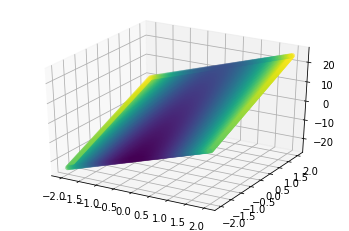

In [12]:
axx = plt.axes(projection='3d')
axx.scatter(x, y, flap(x,y), c=fx(x,y), cmap='viridis', linewidth=0.5)
